## Initialization

In [1]:
import numpy as np
import os
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import pandas as pd
sns.set_style('white')
from math import ceil

In [2]:
data = pd.read_csv('data_all.csv')

In [3]:
# Change nutritional to %
nutrition_lst = ['N', 'K2O', 'P2O5']
    
for n in nutrition_lst:
    data[n + ' (%)'] = data[n] / data[nutrition_lst].sum(axis=1)

for n in nutrition_lst:
    data = data.drop(n, axis = 1)


# Add Yield to the data
data['Yield'] = data['Target'] / data['Cropland (1000 ha)']
data = data.drop('Cropland (1000 ha)', axis = 1)

# Move it to the front
Yield = data.pop('Yield')
data.insert(3, Yield.name, Yield)

In [4]:
# Rename data columns
data.columns = ['Year', 'Country', 'Production', 'Yield', 'Pesticides',
                'Fertilizer (Total)',
                'Agricultural Value Added', 'Mean Temperature', 'Precipitation',
                'Agricultural Employment', 'FPI', 'Population',
                'Agricultural Machinery', 'Export Value',
                'Export Avg Price', 'Import Value',
                'Import Avg Price', 'Urbanization', 'Fertilizer (N%)', 'Fertilizer (K%)',
                'Fertilizer (P%)']


In [5]:
areas_selected = data['Country'].unique()

In [6]:
df = data[data['Country'] == 'Spain']\
                .drop('Country', axis = 1)\
                .set_index('Year')

In [7]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 366 entries, 0 to 365
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Year                      366 non-null    int64  
 1   Country                   366 non-null    object 
 2   Production                366 non-null    int64  
 3   Yield                     360 non-null    float64
 4   Pesticides                186 non-null    float64
 5   Fertilizer (Total)        360 non-null    float64
 6   Agricultural Value Added  312 non-null    float64
 7   Mean Temperature          366 non-null    float64
 8   Precipitation             366 non-null    float64
 9   Agricultural Employment   186 non-null    float64
 10  FPI                       366 non-null    float64
 11  Population                366 non-null    float64
 12  Agricultural Machinery    254 non-null    float64
 13  Export Value              90 non-null     float64
 14  Export Avg

## Comparative Study Across Countries

### Feature Correlation

/var/folders/x9/9jw436052zs7nn0br3pkwdsr0000gn/T/ipykernel_27011/3906940600.py:13: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_by_country[c] = df.corr()['Yield'][2:]
/var/folders/x9/9jw436052zs7nn0br3pkwdsr0000gn/T/ipykernel_27011/3906940600.py:13: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_by_country[c] = df.corr()['Yield'][2:]
/var/folders/x9/9jw436052zs7nn0br3pkwdsr0000gn/T/ipykernel_27011/3906940600.py:13: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr_b

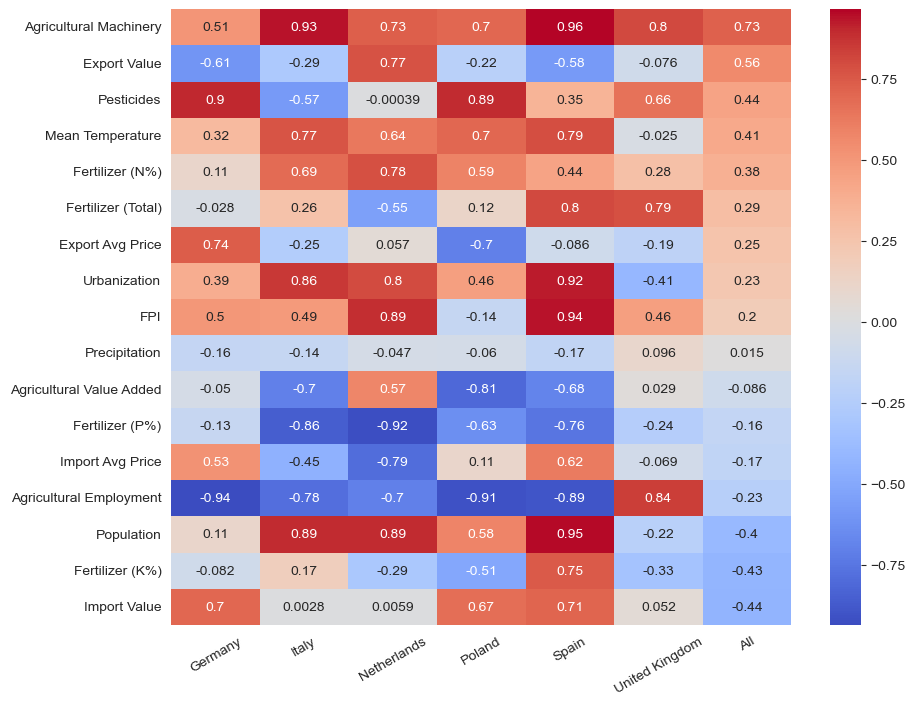

In [8]:
# Calculate the correlation of all countries and years
corr_all = {col: round(data[col].corr(data['Yield']), 3) for col in data.columns[2:]
                if (col != 'Yield') & (col != 'Production')}


corr_all = dict(sorted(corr_all.items(), key =lambda item: item[1], reverse = True))

# Calculate the correlation country by country
corr_by_country = pd.DataFrame()

for c in data['Country'].unique():
    df = data[data['Country'] == c]
    corr_by_country[c] = df.corr()['Yield'][2:]
    

corr_by_country['All'] = corr_all
corr_by_country = corr_by_country.sort_values(by='All', ascending=False)
corr_by_country = corr_by_country[corr_by_country.index != 'Yield']

fig = plt.figure(figsize = (10, 8)) 
sns.heatmap(corr_by_country, annot=True, cmap='coolwarm')
plt.xticks(rotation = 30)
# plt.title('Correlation by country and variable ')
plt.savefig('plot/correlation_by_country.jpeg');


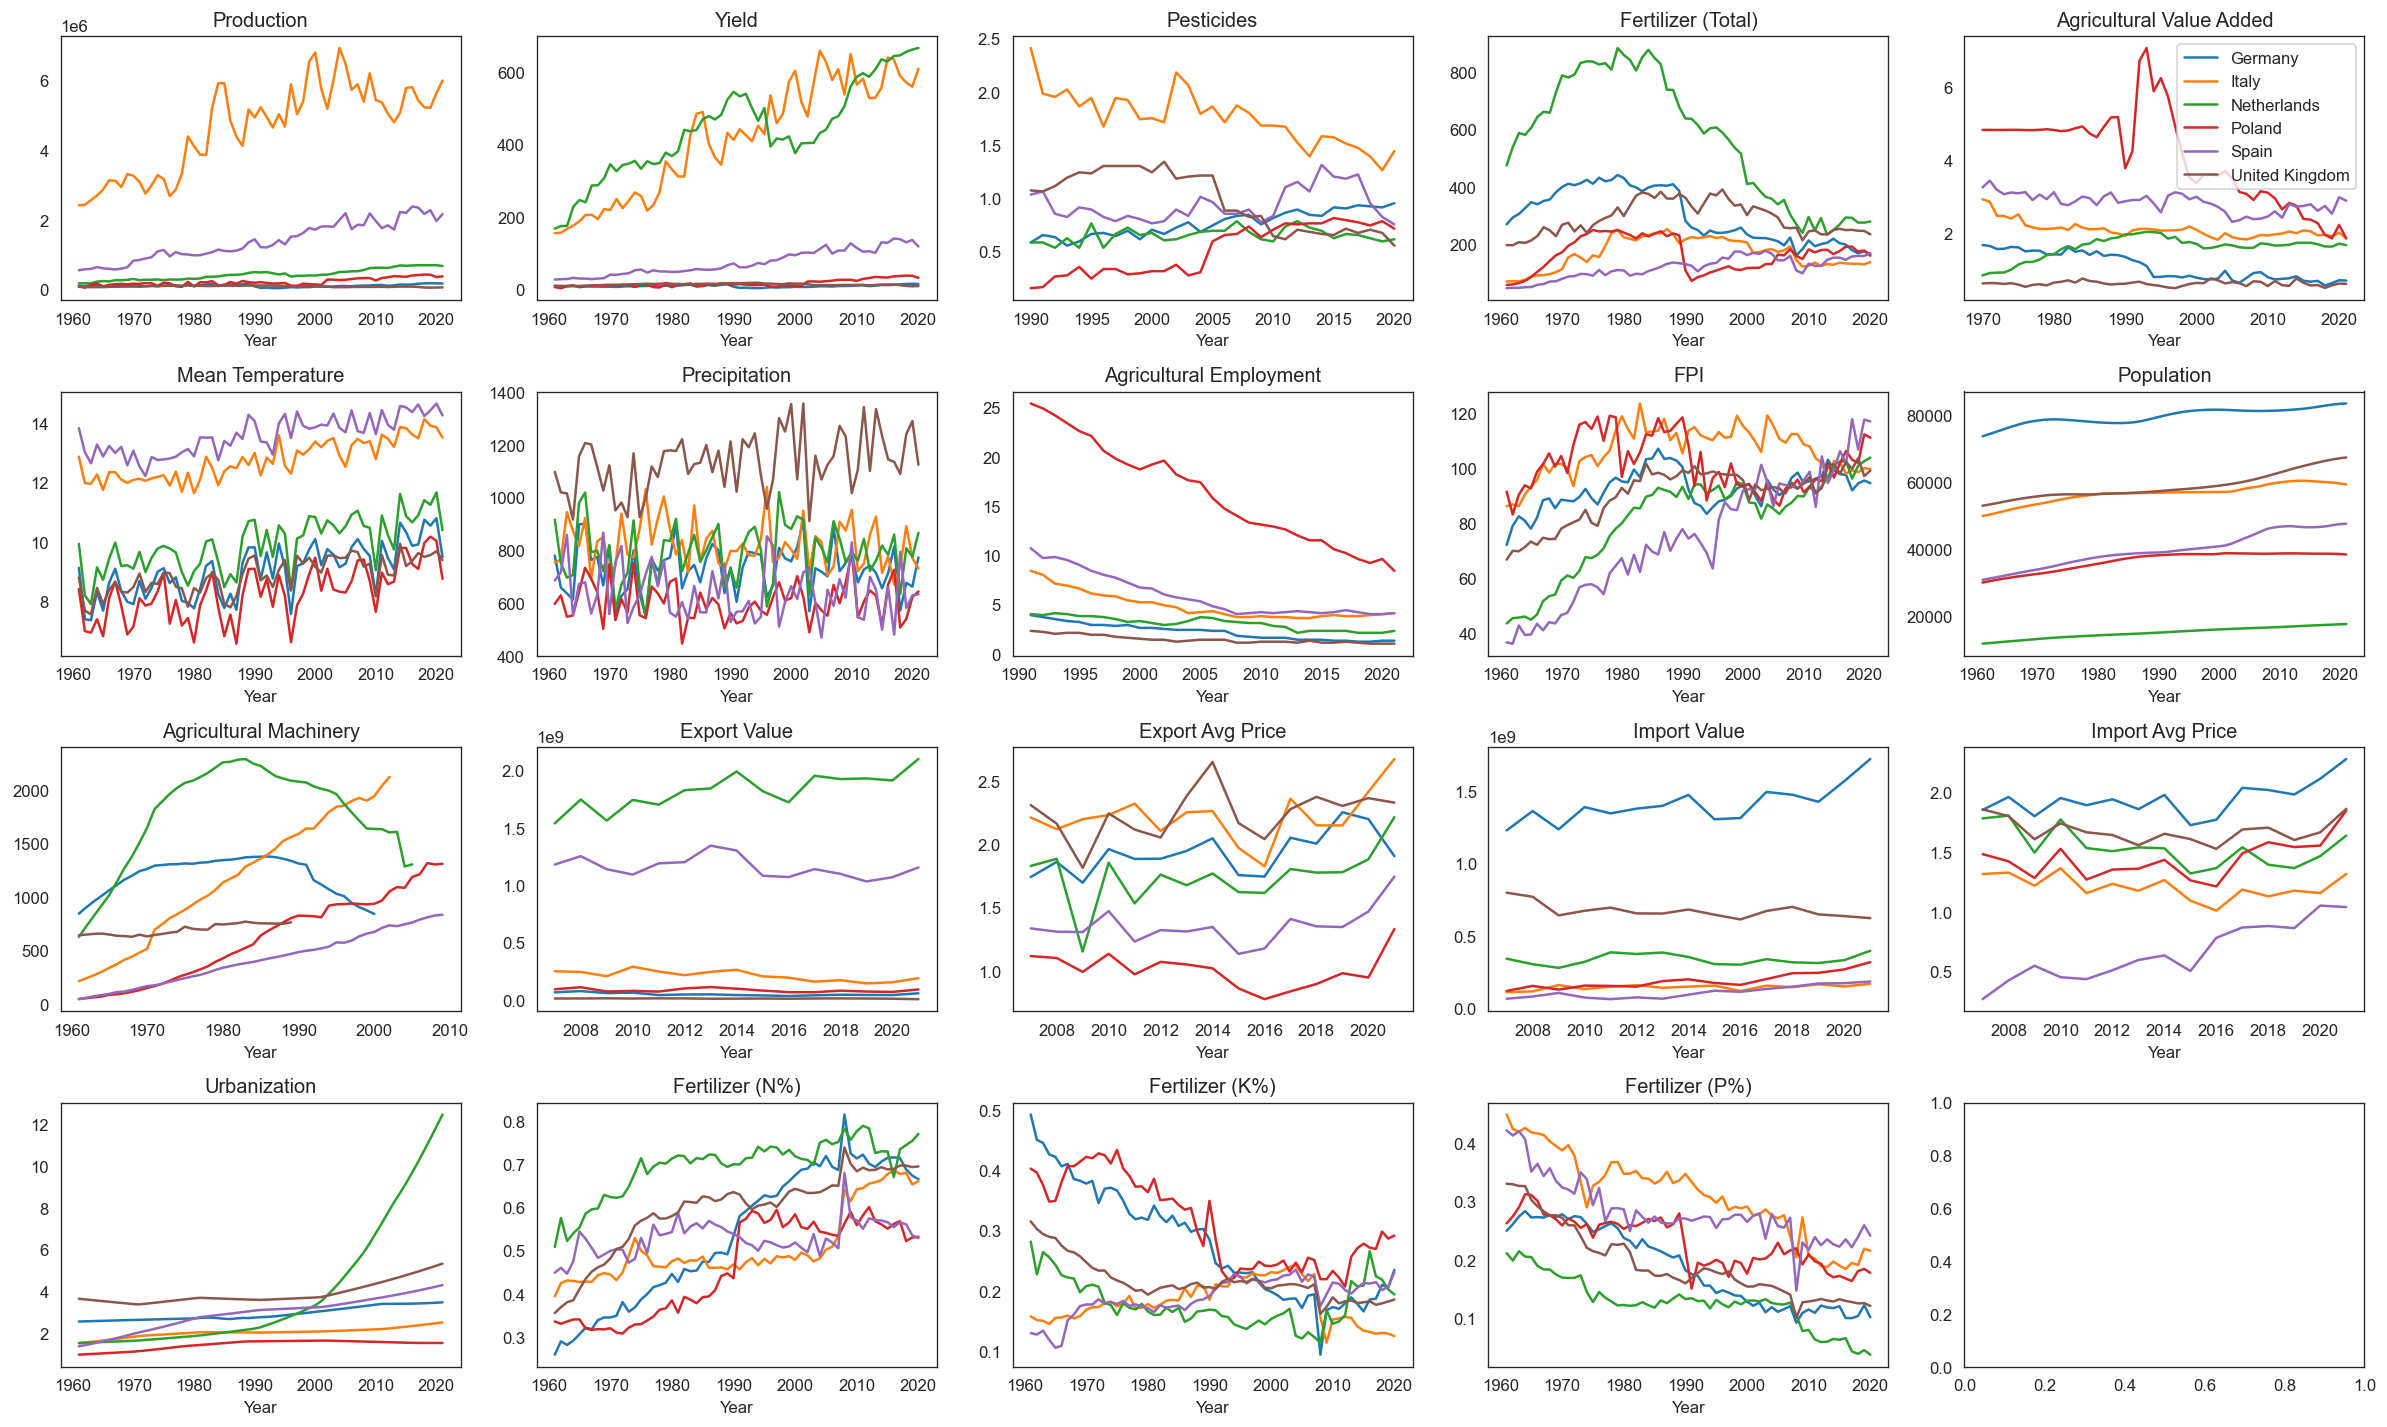

In [9]:
fig, axes = plt.subplots(nrows=ceil(len(data.columns[2:]) / 5),
                         ncols=5,
                         dpi=120,
                         figsize=(20, 12))

for i, (col, ax) in enumerate(zip(data.columns[2:], axes.flatten())):

    sns.lineplot(data=data, x='Year', y=col, hue='Country', ax=ax)

    if i == 4:
        ax.legend(loc='best')

    else:
        ax.legend().set_visible(False)

    ax.set_title(col)
    ax.set_ylabel('')

plt.tight_layout()
plt.savefig('plot/overall.jpeg');


### Production Distribution Across Europe

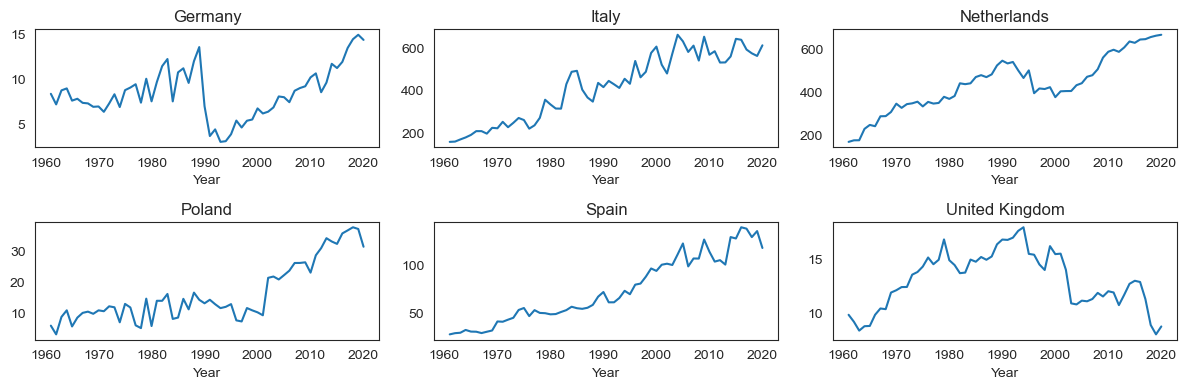

In [10]:
data_long = data[['Country', 'Year', 'Yield']].pivot(index='Year', columns='Country', values='Yield')

fig, ax = plt.subplots(nrows = 2, ncols = 3, figsize = (12, 4))

ax = ax.flatten()

for idx, area in enumerate(areas_selected):
    data_long[area].plot(ax = ax[idx])
    ax[idx].set_title(area)

# plt.suptitle('Tomato Yield By Country')
plt.tight_layout()
plt.savefig('plot/yield_by_country.jpeg');

In [24]:
# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data_long.dropna())

# Compute Euclidean distances between all pairs of columns
euclidean_distances = {}

columns = data_long.columns

for i in range(len(columns)):
    for j in range(len(columns)):
        col1 = normalized_data[:, i]
        col2 = normalized_data[:, j]

        distance = euclidean(col1, col2)
        euclidean_distances[(columns[i], columns[j])] = distance

# Create DataFrame for Euclidean distances
euclidean_distances_df = pd.DataFrame([(key[0], key[1], value) for key, value in euclidean_distances.items()], columns=['Country1', 'Country2', 'Value'])
euclidean_distances_df

,Country1,Country2,Value
0,Germany,Germany,0.000000
1,Germany,Italy,9.723870
2,Germany,Netherlands,8.292349
3,Germany,Poland,7.011720
4,Germany,Spain,8.888591
5,Germany,United Kingdom,12.939258
6,Italy,Germany,9.723870
7,Italy,Italy,0.000000
8,Italy,Netherlands,4.927391
9,Italy,Poland,5.945569


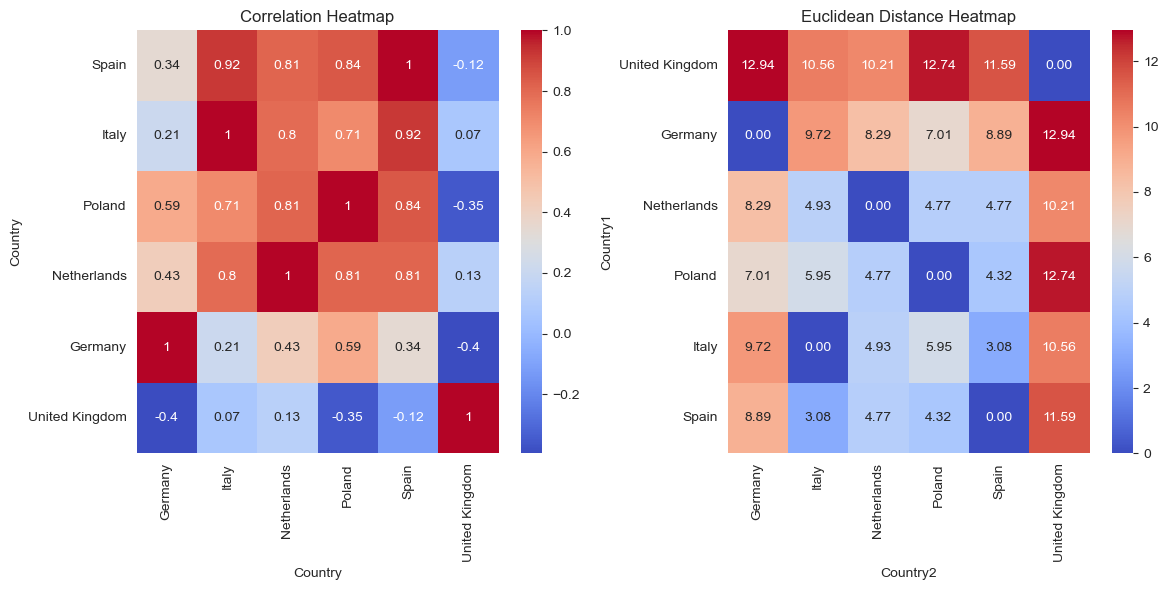

In [23]:
from scipy.spatial.distance import euclidean
from sklearn.preprocessing import StandardScaler

# Normalize the data
scaler = StandardScaler()
normalized_data = scaler.fit_transform(data_long.dropna())

# Compute Euclidean distances between all pairs of columns
euclidean_distances = {}

columns = data_long.columns

for i in range(len(columns)):
    for j in range(len(columns)):
        col1 = normalized_data[:, i]
        col2 = normalized_data[:, j]

        distance = euclidean(col1, col2)
        euclidean_distances[(columns[i], columns[j])] = distance

# Create DataFrame for Euclidean distances
euclidean_distances_df = pd.DataFrame([(key[0], key[1], value) for key, value in euclidean_distances.items()], columns=['Country1', 'Country2', 'Value'])
euclidean_distances_df = euclidean_distances_df.pivot(index='Country1', columns='Country2', values='Value')
euclidean_distances_df = euclidean_distances_df.sort_values(by='Spain', ascending=False)

# Create a figure with subplots
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

# First Subplot: Correlation Heatmap
sns.heatmap(data_long.corr().sort_values(by='Spain', ascending=False), annot=True, ax=ax[0], cmap='coolwarm')
ax[0].set_title('Correlation Heatmap')

# Second Subplot: Euclidean Distance Heatmap
sns.heatmap(euclidean_distances_df, annot=True, cmap='coolwarm', fmt=".2f", ax=ax[1])
ax[1].set_title('Euclidean Distance Heatmap')

# Add a main title and adjust layout
# plt.suptitle('Measuring Similarities Among Countries')
plt.tight_layout()
plt.savefig('plot/measuring_similarity_across_country.jpeg');

In [12]:
target = pd.read_csv('v2/gross production value_tomato.csv')

target['Area'] = target['Area'].replace('United Kingdom of Great Britain and Northern Ireland', 'United Kingdom')
target['Area'] = target['Area'].replace('Netherlands (Kingdom of the)', 'Netherlands')
target = target[target['Element'] == 'Gross Production Value (constant 2014-2016 thousand US$)']

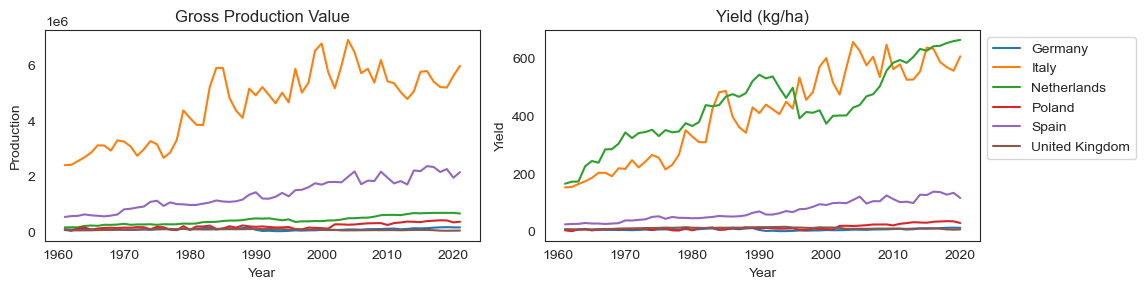

In [13]:
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(10, 3))

# Plot data
sns.lineplot(data=data, x='Year', y='Production', hue='Country', ax=ax[0])
sns.lineplot(data=data, x='Year', y='Yield', hue='Country', ax=ax[1])

# Set titles
ax[0].set_title('Gross Production Value')
ax[1].set_title('Yield (kg/ha)')

# Remove legend from the first subplot
ax[0].legend().set_visible(False)

plt.tight_layout()

# Get the legend for the second subplot
legend = ax[1].legend(loc='upper left', bbox_to_anchor=(1, 1))

# Save the figure
plt.savefig('plot/prod_and_yield.jpeg')

#### Geographical Distribution

/var/folders/x9/9jw436052zs7nn0br3pkwdsr0000gn/T/ipykernel_27011/1874315740.py:5: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


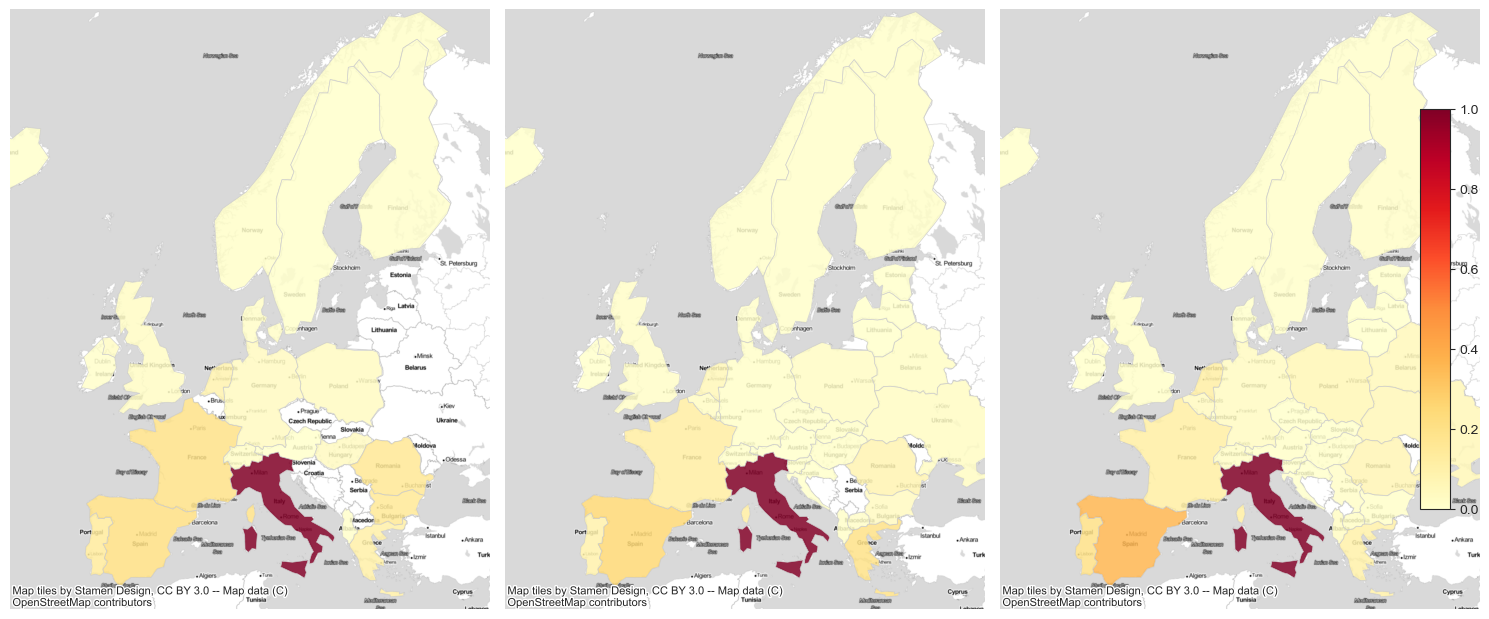

In [14]:
import geopandas as gpd
import contextily as ctx

# Import Geo Data
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
europe = world[world['continent'] == 'Europe']

# Merge tomato production data with GeoDataFrame based on 'Area' column
merged_data = europe.merge(target[['Year', 'Area', 'Value']], left_on='name', right_on='Area')

plot_year = [1965, 2000, 2021]

fig, ax = plt.subplots(nrows=1, ncols=len(plot_year), figsize=(15, 8))

extent = [-2000000, 4000000, 4000000, 11500000]  # [minx, maxx, miny, maxy]

for idx, year in enumerate(plot_year):
    merged_data[merged_data['Year'] == year]\
        .to_crs(epsg=3857) \
        .plot(column='Value', cmap='YlOrRd', linewidth=0.5, edgecolor='0.8', alpha=0.85, ax=ax[idx])

    ax[idx].set_xlim(extent[0], extent[1])
    ax[idx].set_ylim(extent[2], extent[3])

    ctx.add_basemap(ax[idx], source=ctx.providers.Stamen.TonerLite)

    ax[idx].set_axis_off()

# plt.suptitle('Tomato Production in Europe in 1965, 2000, and 2021 (latest)')
plt.tight_layout()

# Add color scale
sm = plt.cm.ScalarMappable(cmap='YlOrRd')
cbar_ax = fig.add_axes([0.95, 0.25, 0.02, 0.5])  # [left, bottom, width, height]
cbar = plt.colorbar(sm, cax=cbar_ax, orientation='vertical')
plt.savefig('plot/geog_plot.jpeg');


#### Growth Rate

In [15]:
cagr_by_area = {}

for Area in data['Country'].unique():

    df = merged_data.loc[merged_data['Area'] == Area, ['Year', 'Value']]

    min_yr = df['Year'].min()
    max_yr = df['Year'].max()

    number_of_periods = max_yr - min_yr

    min_value = df.loc[df['Year'] == min_yr, 'Value'].values[0]
    max_value = df.loc[df['Year'] == max_yr, 'Value'].values[0]

    # Calculate the growth rate (CAGR)
    cagr = (max_value / min_value)**(1 / number_of_periods) - 1

    cagr_by_area[Area] = cagr * 100

# Sort the dictionary by CAGR values in ascending order
sorted_cagr_dict = dict(
    sorted(cagr_by_area.items(), key=lambda item: item[1], reverse=True))

sorted_cagr_dict

{'Poland': 2.374170033180878,
 'Spain': 2.314012007395183,
 'Netherlands': 2.2975805045330144,
 'Italy': 1.5273969715113855,
 'Germany': 0.7933319928836058,
 'United Kingdom': -0.4341685091282743}

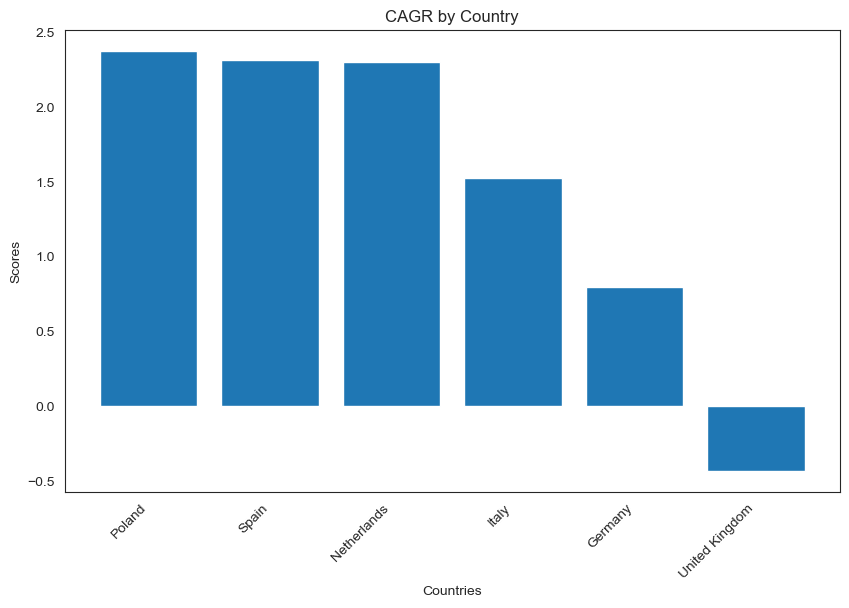

In [16]:
# Create a bar plot
plt.figure(figsize=(10, 6))
plt.bar(sorted_cagr_dict.keys(), sorted_cagr_dict.values())
plt.xlabel('Countries')
plt.ylabel('Scores')
plt.title('CAGR by Country')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.savefig('plot/CAGR_by_country.jpeg');


#### Proportional

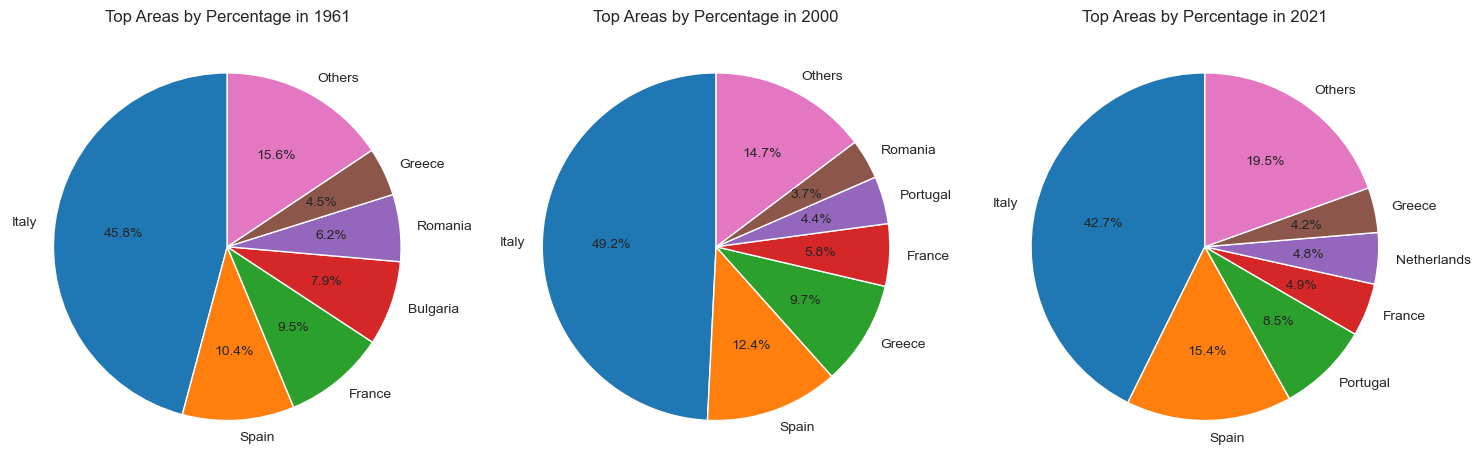

In [17]:

# List of years to analyze
years = [1961, 2000, 2021]

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 6))

for idx, year in enumerate(years):
    # Get data for the specific year
    df = merged_data.loc[merged_data['Year'] == year, ['Area', 'Value']]

    # Calculate the percentage for each area based on the total value for the year
    total_value = df['Value'].sum()
    df['Percentage'] = df['Value'] / total_value * 100

    # Sort the DataFrame by the percentage values in descending order
    df_sorted = df.sort_values(by='Percentage', ascending=False)

    df_sorted = df_sorted.reset_index(drop = True)

    # If there are more than 5 areas, sum the percentages of the rest and add as 'Others'

    max = 6

    if len(df_sorted) > max:
        others_percentage = df_sorted.iloc[max:]['Percentage'].sum()
        others_value = df_sorted.iloc[max:]['Value'].sum()
        df_sorted = df_sorted.iloc[:max]
        df_sorted.loc[max] = ['Others', others_value, others_percentage]

    # Plot the pie chart for the current year
    ax[idx].pie(df_sorted['Percentage'], labels=df_sorted['Area'], autopct='%1.1f%%', startangle=90)
    ax[idx].set_title(f'Top Areas by Percentage in {year}')

plt.tight_layout()
plt.savefig('plot/total_prod_pie.jpeg');


#### Histogram

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that 

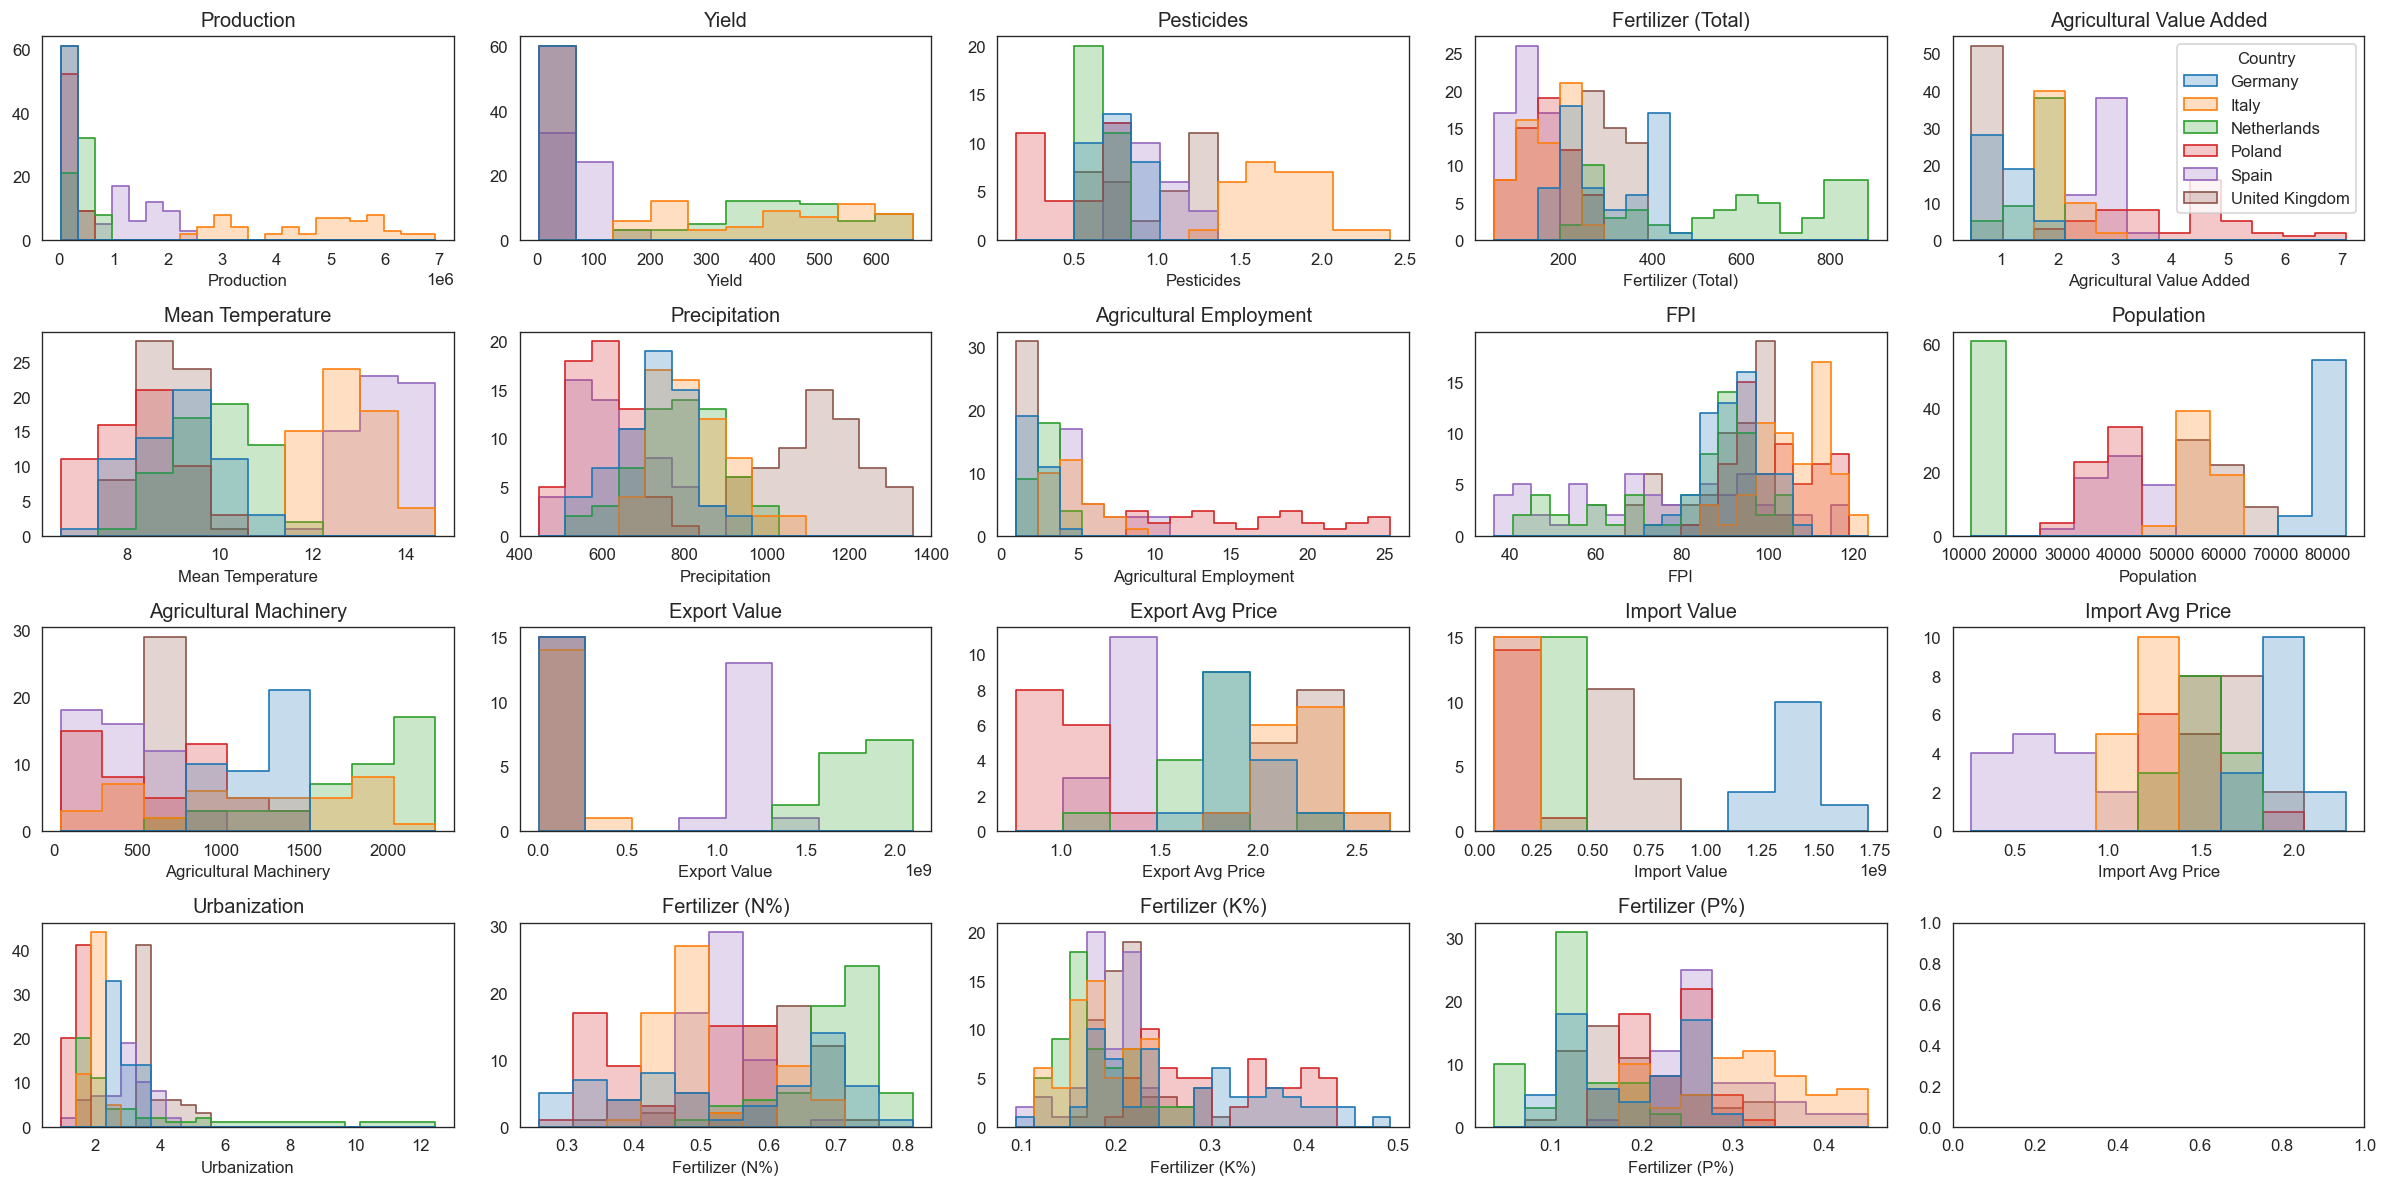

In [18]:
from math import ceil

fig, ax = plt.subplots(nrows=ceil(len(data.columns[2:])/5), ncols = 5, dpi=120, figsize=(20,10))

ax = ax.flatten()

for idx, col in enumerate(data.columns[2:]):

      histplot = sns.histplot(data = data, x = col, hue='Country', element="step", legend = 'full', ax = ax[idx])

      if idx != 4:
        histplot.legend().set_visible(False) 

      ax[idx].set_title(col)
      ax[idx].set_ylabel('')

plt.tight_layout()
plt.savefig('plot/hist.jpeg');

### Weather as an Infuencing  

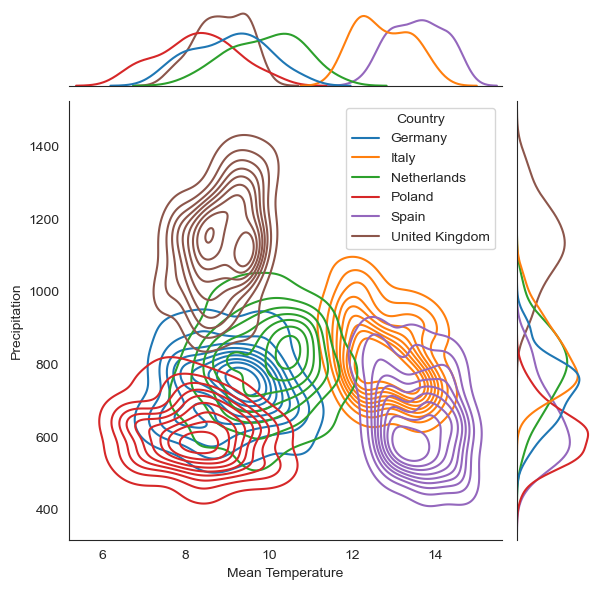

In [19]:

# plt.figure(figsize = (10, 6))

sns.jointplot(x= 'Mean Temperature',
            y= "Precipitation",
            data = data,
            hue='Country', kind = 'kde')

# Set the title and labels (optional)
# plt.title('Temperature vs. Precipitation')
plt.xlabel('Mean Temperature')
plt.ylabel('Precipitation')

plt.savefig('plot/temp_vs_prep.jpeg');

### Fertilizer Nutritional Breakdown as a Influencing Factor

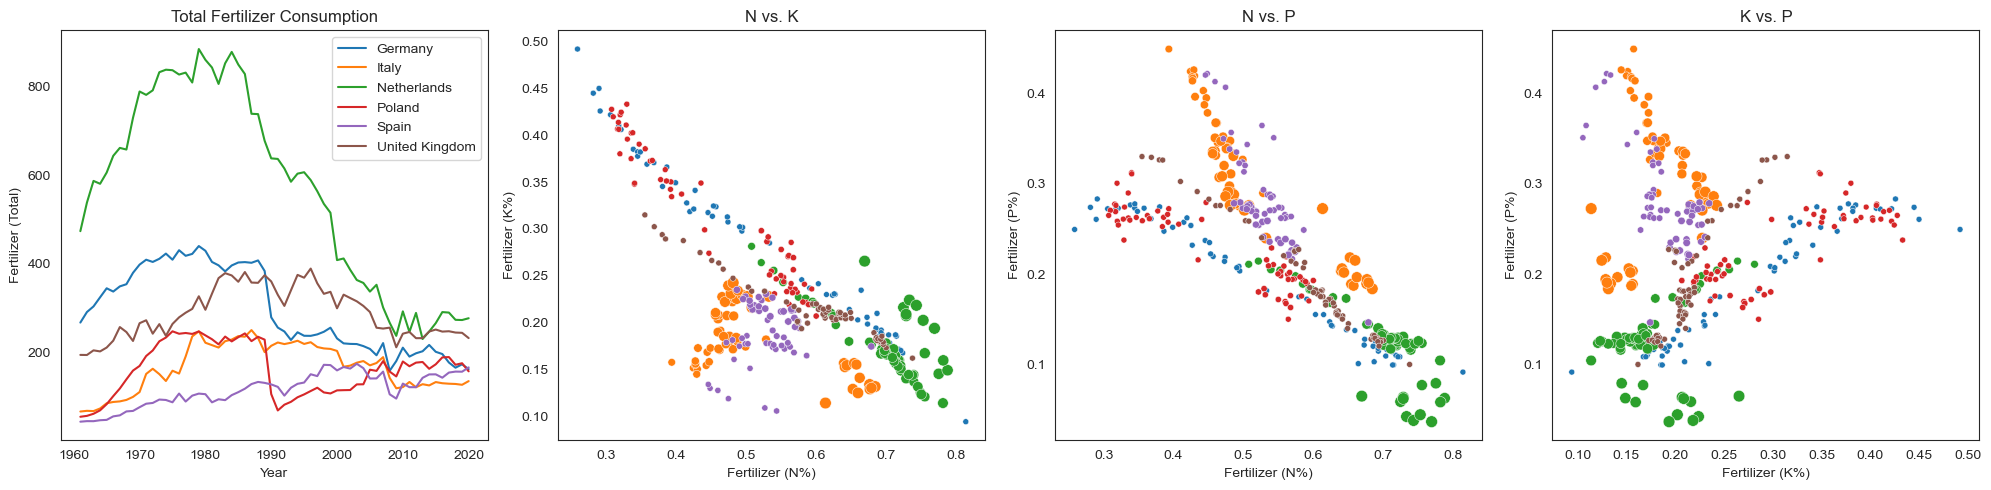

In [20]:
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations

# Create a new figure with a 1x4 grid
fig, axes = plt.subplots(nrows=1, ncols=4, figsize=(20, 5))  # Adjust figsize as needed

# Plot 1: Lineplot
sns.lineplot(data=data, x='Year', y='Fertilizer (Total)', hue='Country', ax=axes[0])
axes[0].set_title('Total Fertilizer Consumption')
axes[0].legend().set_visible(True)  # Adjust the legend as needed

# Generate combinations of nutritional features
combinations_list = list(combinations(['N', 'K', 'P'], 2))

# Loop through combinations and create scatter plots
for idx, item in enumerate(combinations_list):
    # Create a scatter plot for the current combination
    sns.scatterplot(
        x='Fertilizer (' + item[0] + '%)',
        y='Fertilizer (' + item[1] + '%)',
        data=data,
        hue='Country',
        size='Yield',
        ax=axes[idx + 1]  # Use the appropriate subplot axis
    )
    
    axes[idx + 1].set_title(f'{item[0]} vs. {item[1]}')
    axes[idx + 1].legend().set_visible(False)

# Adjust layout
plt.tight_layout()

# Save the combined plot
plt.savefig('plot/combined_fertilizer_plots.jpeg');

### Exports and Imports as an Influencing Factor

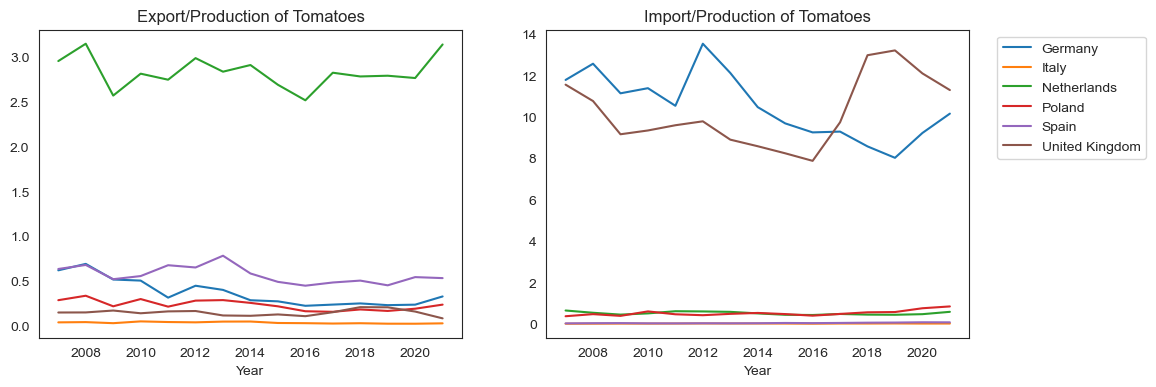

In [21]:
# Create a figure
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize=(12, 4))

for c in data['Country'].unique():
    df = data.loc[data['Country'] == c, ['Year', 'Production', 'Export Value',
                                     'Import Value']]
    df = df.set_index('Year')
    df['Export (%)'] = df['Export Value'] / (df['Production'] * 1000)
    df['Import (%)'] = df['Import Value'] / (df['Production'] * 1000)

    # print(c)
    # display(df['Export (%)'][df['Export (%)'].notna()].head(3))
    # display(df['Import (%)'][df['Export (%)'].notna()].head(3))
    # print('\n')

    # Plotting the export percentage with a label
    df['Export (%)'].plot(label=c, ax = ax[0])
    df['Import (%)'].plot(label=c, ax = ax[1])


# Adding labels and title
ax[0].set_title('Export/Production of Tomatoes')
ax[1].set_title('Import/Production of Tomatoes')

ax[0].legend().set_visible(False)
ax[1].legend(bbox_to_anchor = (1.05, 1), loc = 'upper left')
plt.savefig('plot/export_and_import.jpeg');

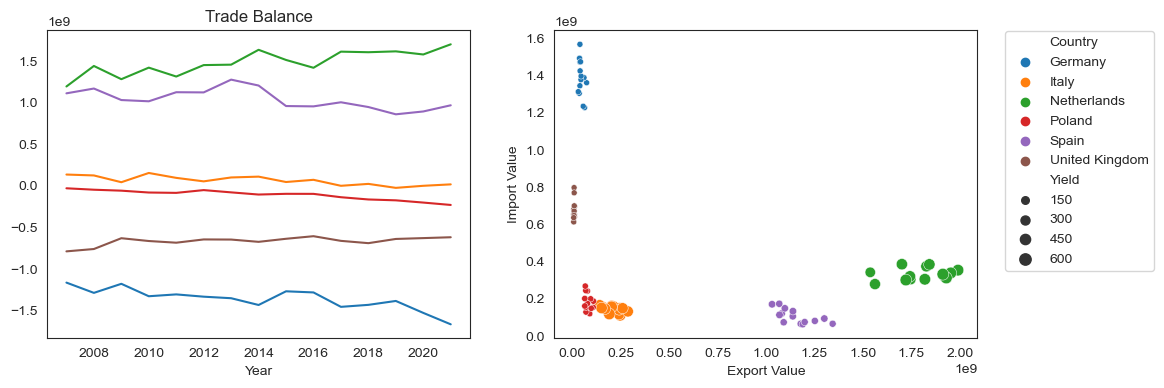

In [22]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (12, 4))

for c in areas_selected:

    df = data[data['Country'] == c]\
                .drop('Country', axis = 1)\
                .set_index('Year')

    (df['Export Value'] - df['Import Value']).plot(label = c, ax = ax[0])

ax[0].set_title('Trade Balance')
ax[0].legend()

sns.scatterplot(
        x = 'Export Value',
        y = 'Import Value',
        data = data,
        hue = 'Country',
        size = 'Yield', ax = ax[1])


# sns.scatterplot(
#         x = 'Export Avg Price',
#         y = 'Import Avg Price',
#         data = data,
#         hue = 'Country',
#         size = 'Yield', ax = ax[2])

ax[0].legend().set_visible(False)
ax[1].legend(bbox_to_anchor = (1.05, 1.02), loc = 'upper left')

plt.savefig('plot/trade_dynamics.jpeg');